# Import Packages and Dataset

## Packages

In [1]:
!pip install transformers

     |████████████████████████████████| 573kB 2.7MB/s 
     |████████████████████████████████| 890kB 9.3MB/s 
     |████████████████████████████████| 1.0MB 16.0MB/s 
     |████████████████████████████████| 3.7MB 30.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=5803838aacb23144c400deeb9cac4b8bd2ef79131625b314d572e36c88d2d873
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
%tensorflow_version 2.x

In [3]:
import torch
import transformers as tfm # pytorch transformers
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_train_full_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [23]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang kind enough show look kelas teman kampu...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,nyata komunis menang
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user bom embel bom takut orang orang korban
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya habis iya olimpiade pagelaran...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,user user user user user fungsi medium sosial ...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_test_full_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [25]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng berengsek think nothing remember
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,insult one cina kafir make good muslim
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user partai partai demokrasi indonesia ju...
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user salah janji jokowi tuntut paham kece...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_val_full_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [27]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,much berengsek people world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,get rekening berengsek rekening berengsek
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,user dasar bajing
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user kecebong pria lajang lulu sastra profesor...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,user urus monyet break home teman teman kaya r...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1).values

# BERT Model

In [0]:
model_class, tokenizer_class, pretrained_weights = (tfm.BertModel, tfm.BertTokenizer, 'bert-base-multilingual-cased')

## Load Tokenizer and Model

In [0]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Tokenize Train Set, Validation Set, and Test Set

In [0]:
train_sequences = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
validation_sequences = X_val.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
test_sequences = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
train_padded = sequence.pad_sequences(train_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
validation_padded = sequence.pad_sequences(validation_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
test_padded = sequence.pad_sequences(test_sequences, maxlen=100, padding="post", truncating="post")

## Change Padded to Tensor and Run Model (Forward Pass)

In [0]:
import pickle

In [38]:
train_ids = torch.tensor(np.array(train_padded)).to(torch.int64)
train_features = []
batch_size = 500
for batch in tqdm(range(0,len(train_ids),batch_size)):
  with torch.no_grad():
    train_last_hidden_states = model(train_ids[batch:batch+batch_size])
    train_features.append(train_last_hidden_states[0])
# train_features = train_features.numpy()


100%|██████████| 27/27 [27:56<00:00, 62.08s/it]


In [0]:
train_features = np.concatenate(train_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_train_full_3d.pkl', 'wb') as f:
  pickle.dump(train_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_y_train_full_3d.pkl', 'wb') as f:
  pickle.dump(y_train, f)

In [41]:
validation_ids = torch.tensor(np.array(validation_padded)).to(torch.int64)
validation_features = []
batch_size = 500
for batch in tqdm(range(0,len(validation_ids),batch_size)):
  with torch.no_grad():
    validation_last_hidden_states = model(validation_ids[batch:batch+batch_size])
    validation_features.append(validation_last_hidden_states[0])


100%|██████████| 3/3 [03:17<00:00, 65.70s/it]


In [0]:
validation_features = np.concatenate(validation_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_validation_full_3d.pkl', 'wb') as f:
  pickle.dump(validation_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_y_validation_full_3d.pkl', 'wb') as f:
  pickle.dump(y_val, f)

In [44]:
test_ids = torch.tensor(np.array(test_padded)).to(torch.int64)
test_features = []
batch_size = 500
for batch in tqdm(range(0,len(test_ids),batch_size)):
  with torch.no_grad():
    test_last_hidden_states = model(test_ids[batch:batch+batch_size])
    test_features.append(test_last_hidden_states[0])


100%|██████████| 8/8 [07:58<00:00, 59.76s/it]


In [0]:
test_features = np.concatenate(test_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_test_full_3d.pkl', 'wb') as f:
  pickle.dump(test_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_y_test_full_3d.pkl', 'wb') as f:
  pickle.dump(y_test, f)

In [47]:
train_features.shape

(13244, 100, 768)

In [48]:
validation_features.shape

(1472, 100, 768)

In [49]:
test_features.shape

(3680, 100, 768)

In [50]:
while 1:
  print("",end="")

KeyboardInterrupt: ignored

# Classification

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_train_full_3d.pkl', 'rb') as f:
  train_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_y_train_full_3d.pkl', 'rb') as f:
  y_train = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_validation_full_3d.pkl', 'rb') as f:
  validation_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_y_validation_full_3d.pkl', 'rb') as f:
  y_validation = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_test_full_3d.pkl', 'rb') as f:
  test_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Bert Data/bert_y_test_full_3d.pkl', 'rb') as f:
  y_test = pickle.load(f)

## Define Model

In [51]:
model = Sequential()
# Configuring the parameters
model.add(InputLayer((100,768)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               426496    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 435,532
Trainable params: 435,532
Non-trainable params: 0
_________________________________________________________________


## Training Model with Adam Optimizer

In [52]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_features, y_train, 
                    validation_data=(validation_features, y_val),
                    epochs=15, batch_size=32, 
                    verbose=2)

Epoch 1/15
414/414 - 6s - loss: 0.3608 - accuracy: 0.5672 - val_loss: 0.3475 - val_accuracy: 0.5550
Epoch 2/15
414/414 - 6s - loss: 0.3234 - accuracy: 0.5857 - val_loss: 0.3209 - val_accuracy: 0.5190
Epoch 3/15
414/414 - 6s - loss: 0.3021 - accuracy: 0.5421 - val_loss: 0.3074 - val_accuracy: 0.6121
Epoch 4/15
414/414 - 6s - loss: 0.2847 - accuracy: 0.5066 - val_loss: 0.3015 - val_accuracy: 0.4925
Epoch 5/15
414/414 - 6s - loss: 0.2747 - accuracy: 0.4878 - val_loss: 0.2991 - val_accuracy: 0.5387
Epoch 6/15
414/414 - 6s - loss: 0.2623 - accuracy: 0.4724 - val_loss: 0.2948 - val_accuracy: 0.4524
Epoch 7/15
414/414 - 6s - loss: 0.2514 - accuracy: 0.4572 - val_loss: 0.2947 - val_accuracy: 0.3145
Epoch 8/15
414/414 - 6s - loss: 0.2404 - accuracy: 0.4494 - val_loss: 0.2876 - val_accuracy: 0.4654
Epoch 9/15
414/414 - 6s - loss: 0.2321 - accuracy: 0.4526 - val_loss: 0.2952 - val_accuracy: 0.3281
Epoch 10/15
414/414 - 6s - loss: 0.2208 - accuracy: 0.4443 - val_loss: 0.2957 - val_accuracy: 0.3967

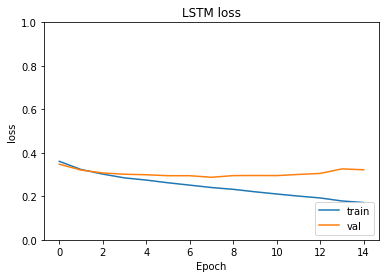

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Predict and Result

In [0]:
predict = model.predict(test_features)
predict_train = model.predict(train_features)
predict_val = model.predict(validation_features)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [56]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test,pred_test)
haml_loss = hamming_loss(y_test,pred_test)
label_acc = labelSetAccuracy(y_test,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.4989130434782609
hamming loss =  0.12212409420289855
label based accuracy =  0.6167498059006212


In [57]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train,pred_train)
haml_loss = hamming_loss(y_train,pred_train)
label_acc = labelSetAccuracy(y_train,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.6824222289338568
hamming loss =  0.059964260545655894
label based accuracy =  0.8029623776924442


In [58]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val,pred_val)
haml_loss = hamming_loss(y_val,pred_val)
label_acc = labelSetAccuracy(y_val,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.48777173913043476
hamming loss =  0.12930253623188406
label based accuracy =  0.6170322204968943


## Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modelBERT_full.h5')

# Analysis Predict

In [0]:
target = data_train.columns[1:-1]

## Data Validation Predict Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(y_val,columns=target)).reset_index(drop=True)

In [61]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,much berengsek people world,1,1,0,1,0,0,0,0,1,0,1,0
1,get rekening berengsek rekening berengsek,0,1,0,0,0,0,0,0,0,0,0,0
2,user dasar bajing,0,1,0,0,0,0,0,0,0,0,0,0
3,user kecebong pria lajang lulu sastra profesor...,1,1,0,1,0,0,0,0,1,0,1,0
4,user urus monyet break home teman teman kaya r...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=target))

In [63]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,much berengsek people world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,get rekening berengsek rekening berengsek,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user dasar bajing,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,user kecebong pria lajang lulu sastra profesor...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,user urus monyet break home teman teman kaya r...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

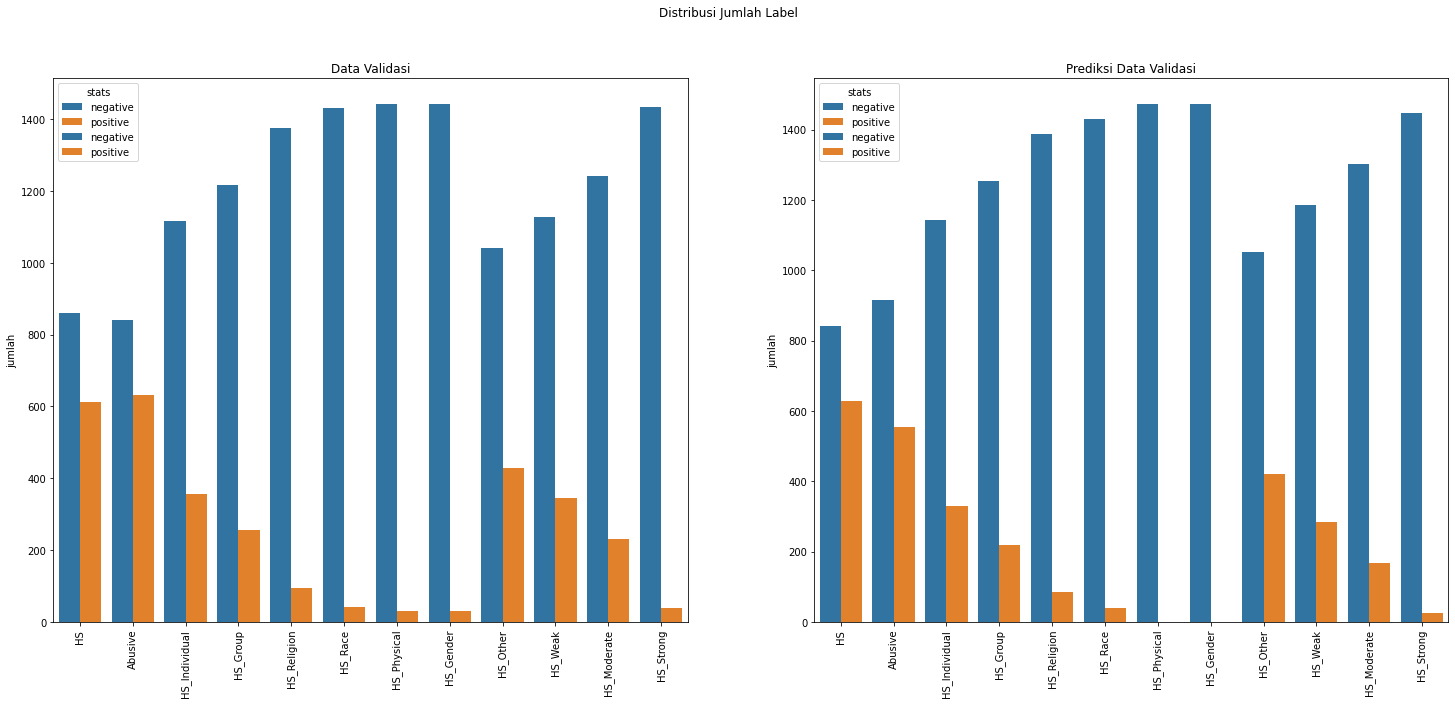

In [66]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [67]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,843,629
1,Abusive,840,632,917,555
2,HS_Individual,1115,357,1143,329
3,HS_Group,1216,256,1253,219
4,HS_Religion,1376,96,1387,85
5,HS_Race,1431,41,1431,41
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1472,0
8,HS_Other,1042,430,1051,421
9,HS_Weak,1128,344,1187,285


### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
vocab = tokenizer.ids_to_tokens.values()

In [72]:
tokenizer.ids_to_tokens.values()

odict_values(['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused70]', '[unus

In [0]:
oov_val = oov(vocab, generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [74]:
oov_val_count

{'berengsek': 13,
 'bajing': 9,
 'urus': 7,
 'monyet': 8,
 'celeng': 2,
 'synna': 1,
 'emosi': 1,
 'mancing': 1,
 'malaysia': 51,
 'infinit': 1,
 'tunggu': 4,
 'timnas': 5,
 'shame': 33,
 'sinting': 2,
 'minum': 3,
 'obat': 1,
 'bacot': 9,
 'bahas': 4,
 'rusak': 5,
 'revitalisasi': 1,
 'didik': 4,
 'kafir': 37,
 'banci': 16,
 'ampun': 1,
 'sedih': 3,
 'cong': 3,
 'kayak': 11,
 'bodoh': 19,
 'keleees': 1,
 'lihat': 24,
 'ganti': 29,
 'ogah': 1,
 'sendu': 1,
 'gila': 17,
 'ajar': 9,
 'maksud': 3,
 'kucing': 2,
 'joke': 4,
 'laugh': 2,
 'pilih': 33,
 'mend': 7,
 'latih': 2,
 'bosan': 1,
 'monoton': 1,
 'jual': 4,
 'citra': 5,
 'pasang': 6,
 'wajah': 2,
 'melas': 1,
 'bangsat': 34,
 'expect': 2,
 'fuck': 46,
 'deserve': 3,
 'jembut': 3,
 'tuduh': 5,
 'komunis': 39,
 'indonesia': 134,
 'jokowi': 63,
 'kampanye': 5,
 'useruser': 1,
 'memframing': 1,
 'olah': 3,
 'suci': 6,
 'rocky': 2,
 'kecebong': 32,
 'leyeh': 2,
 'tonton': 4,
 'busuk': 4,
 'nyata': 7,
 'anjir': 5,
 'butterbean': 1,
 'duit

In [76]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  4265
number of unique OOV words :  1709


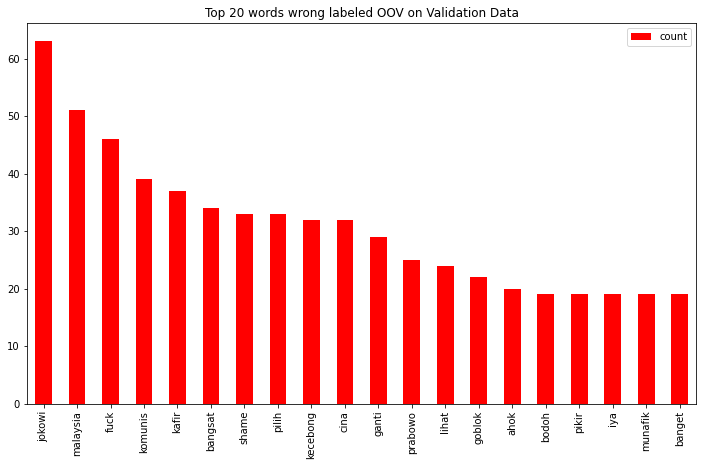

In [77]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

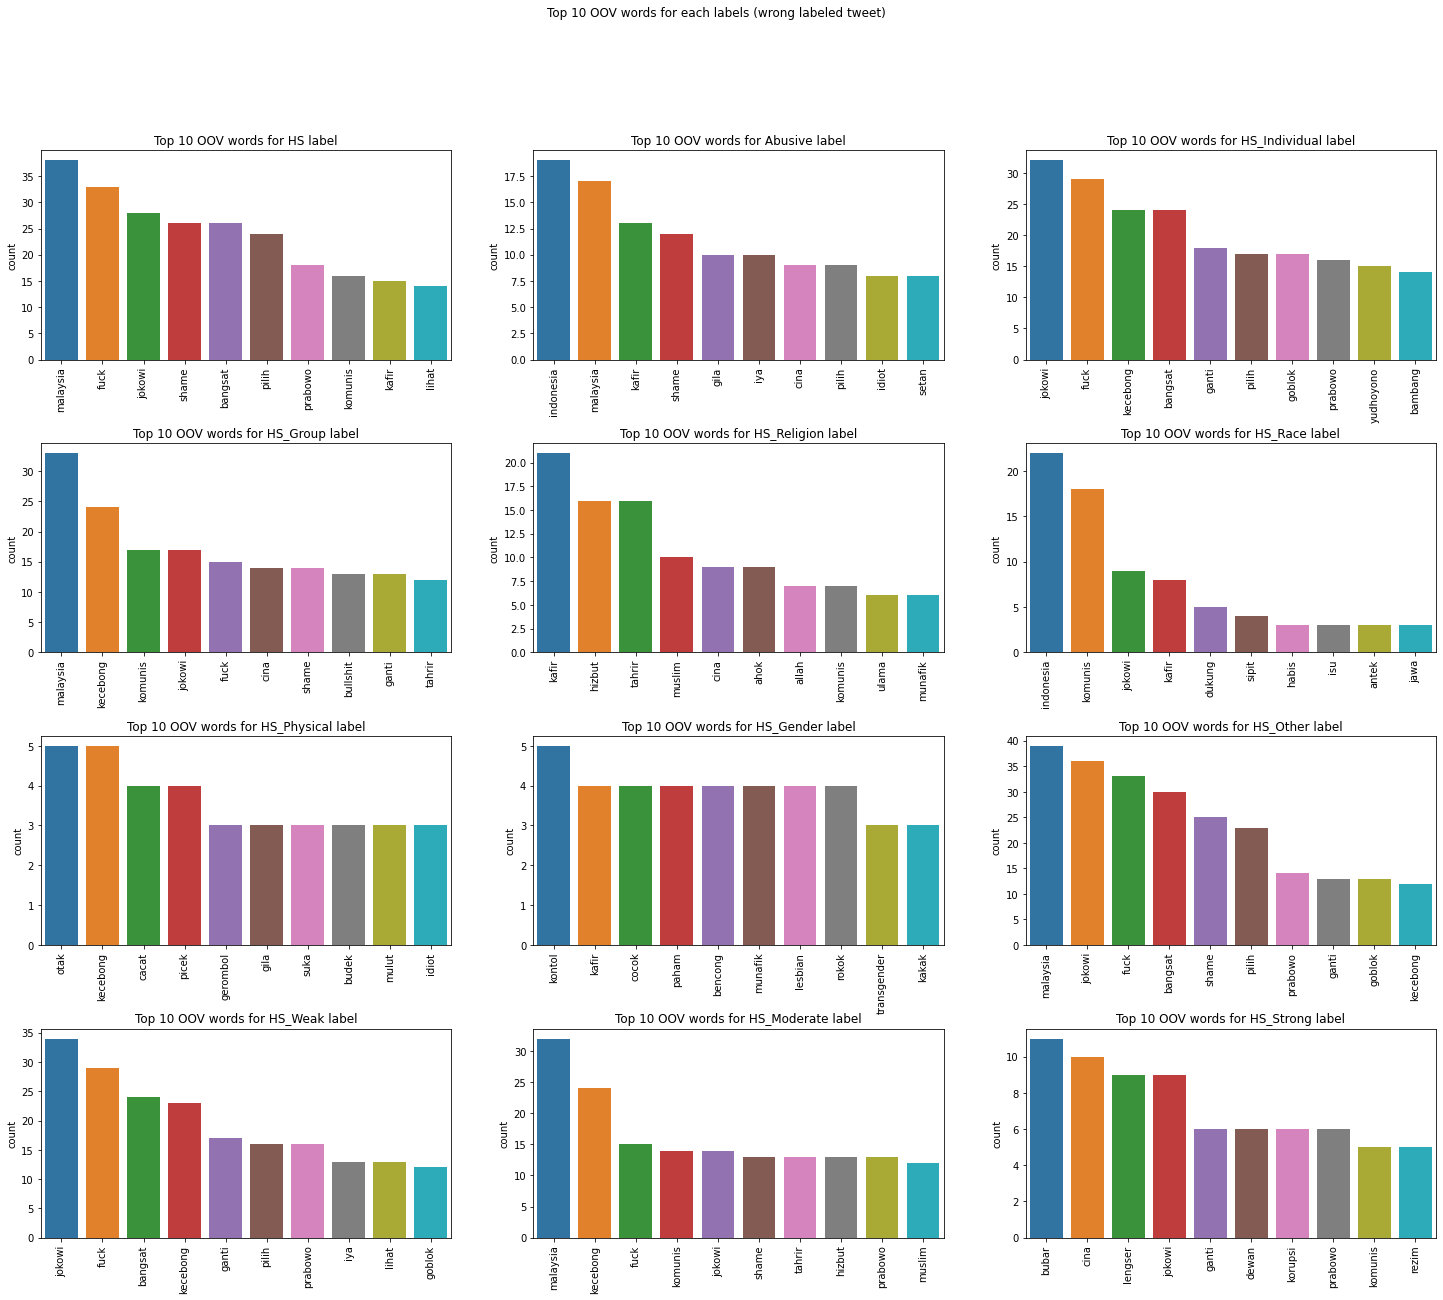

In [78]:

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [79]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['much berengsek people world',
 'user dasar bajing',
 'user urus monyet break home teman teman kaya raya h',
 'user user celeng synna emosi mancing',
 'malaysia defeat infinit tunggu timnas day shame malaysia',
 'sinting minum obat',
 'user user bacot',
 'bahas islam rusak nilai user kuat karakter revitalisasi didik nilai',
 'user kafir banci ampun kafir banci sedih cong google kafir banci kayak',
 'user bodoh pengaruh keleees lihat poll google presiden ganti ganti presiden ogah ganti presiden',
 'sendu gila',
 'ajar point maksud anjing predator kucing prey think get back school joke around laugh',
 'user pilih kepala daerah menang mend vote nama poll kali latih timnas',
 'user user bosan gaya monoton gaya jual citra pasang wajah melas rakyat',
 'know bangsat need expect anything fuck loser',
 'deserve date user jembut',
 'user tuduh user partai komunis indonesia jokowi anti islam rakyat percaya kampanye contoh useruser user',
 'user user memframing olah kitab suci milik umat islam um

In [80]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [81]:
miss_exact_tweet_val.iloc[:,1:-12].values.tolist()

[[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0,

In [82]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Data Test Predict Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=target)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

### Check Number of Labels on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[2:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[2:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[2:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[2:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[2:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

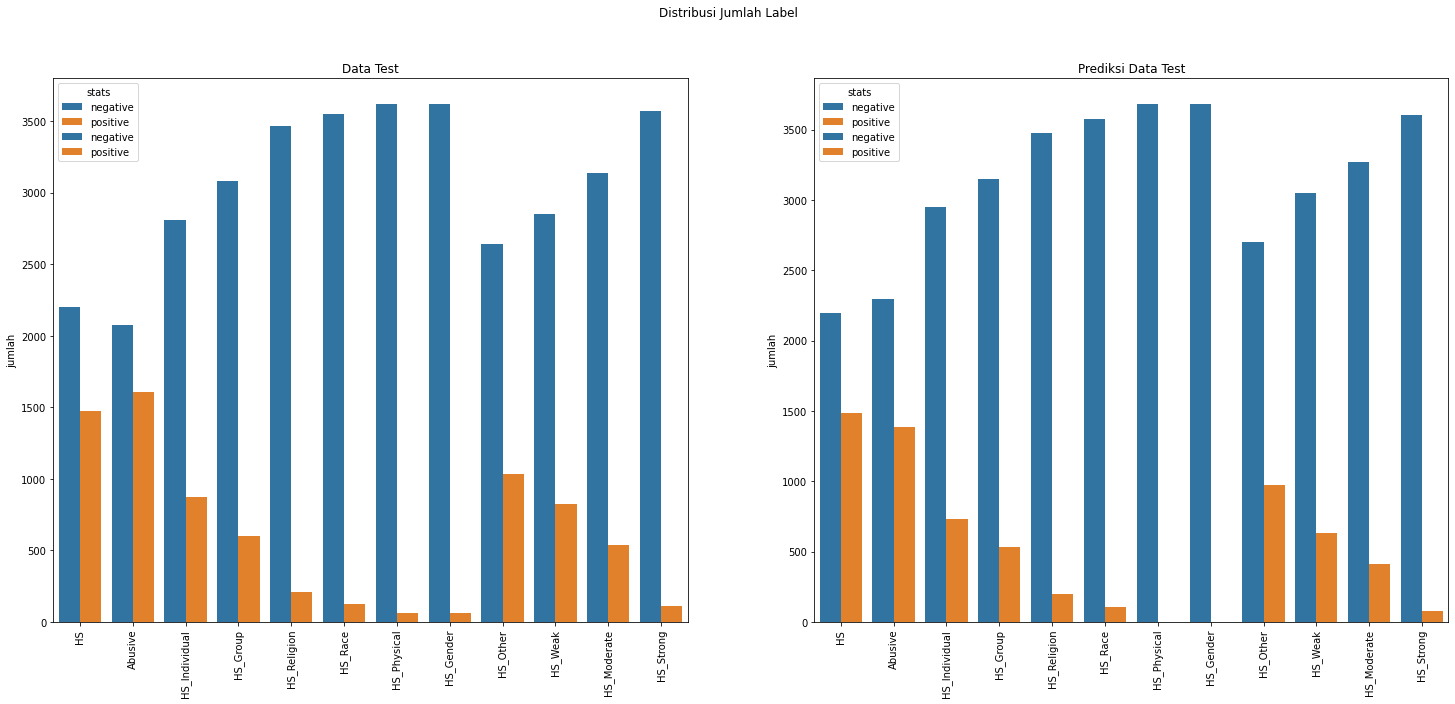

In [99]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [100]:
pd.DataFrame({
    "label" : data_test.columns[2:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2196,1484
1,Abusive,2075,1605,2296,1384
2,HS_Individual,2806,874,2950,730
3,HS_Group,3078,602,3149,531
4,HS_Religion,3467,213,3479,201
5,HS_Race,3551,129,3576,104
6,HS_Physical,3617,63,3680,0
7,HS_Gender,3616,64,3680,0
8,HS_Other,2643,1037,2705,975
9,HS_Weak,2854,826,3050,630


### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak_predict"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate_predict"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong_predict"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vocab, generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [105]:
oov_test_count

{'ganteng': 7,
 'berengsek': 29,
 'insult': 2,
 'cina': 90,
 'kafir': 97,
 'muslim': 48,
 'ajar': 23,
 'garong': 1,
 'pecun': 9,
 'hobi': 1,
 'zina': 1,
 'hamdalah': 1,
 'fitur': 1,
 'keparat': 6,
 'tasik': 1,
 'iktiraf': 1,
 'rizab': 1,
 'biosfera': 1,
 'unesco': 1,
 'sungguh': 5,
 'khazanah': 1,
 'giat': 3,
 'lombong': 1,
 'ladang': 1,
 'hibah': 1,
 'tawar': 3,
 'didik': 5,
 'lepas': 4,
 'ijazah': 4,
 'dpli': 1,
 'sarjana': 1,
 'ismppi': 1,
 'unisza': 1,
 'sukacita': 1,
 'maklum': 6,
 'universitas': 1,
 'zainal': 1,
 'nyata': 26,
 'kriteria': 1,
 'iya': 52,
 'jablay': 10,
 'indonesia': 272,
 'suffocate': 1,
 'tonton': 11,
 'sampah': 16,
 'burn': 2,
 'astaga': 4,
 'sewa': 1,
 'pilih': 62,
 'bangkai': 25,
 'karang': 1,
 'cheat': 20,
 'shame': 70,
 'malaysia': 127,
 'beli': 15,
 'kirim': 4,
 'paket': 2,
 'pork': 1,
 'najis': 27,
 'dirty': 5,
 'akin': 1,
 'urine': 2,
 'pikir': 29,
 'temptation': 1,
 'fake': 2,
 'liar': 18,
 'nobody': 4,
 'educate': 1,
 'upin': 1,
 'ipin': 1,
 'munafik': 

In [107]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  10624
number of unique OOV words :  3236


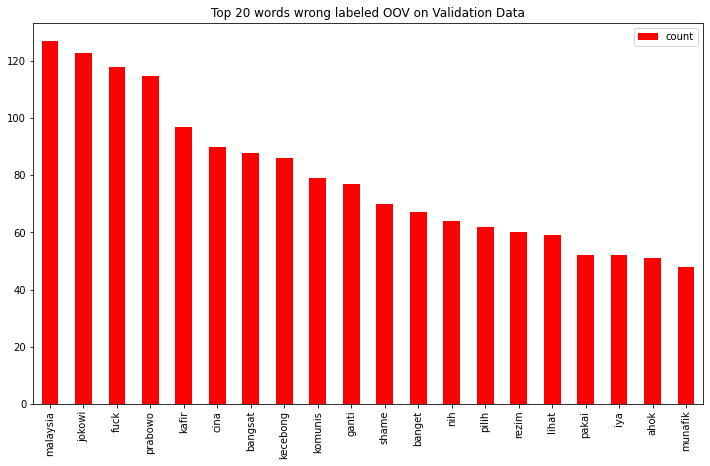

In [108]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

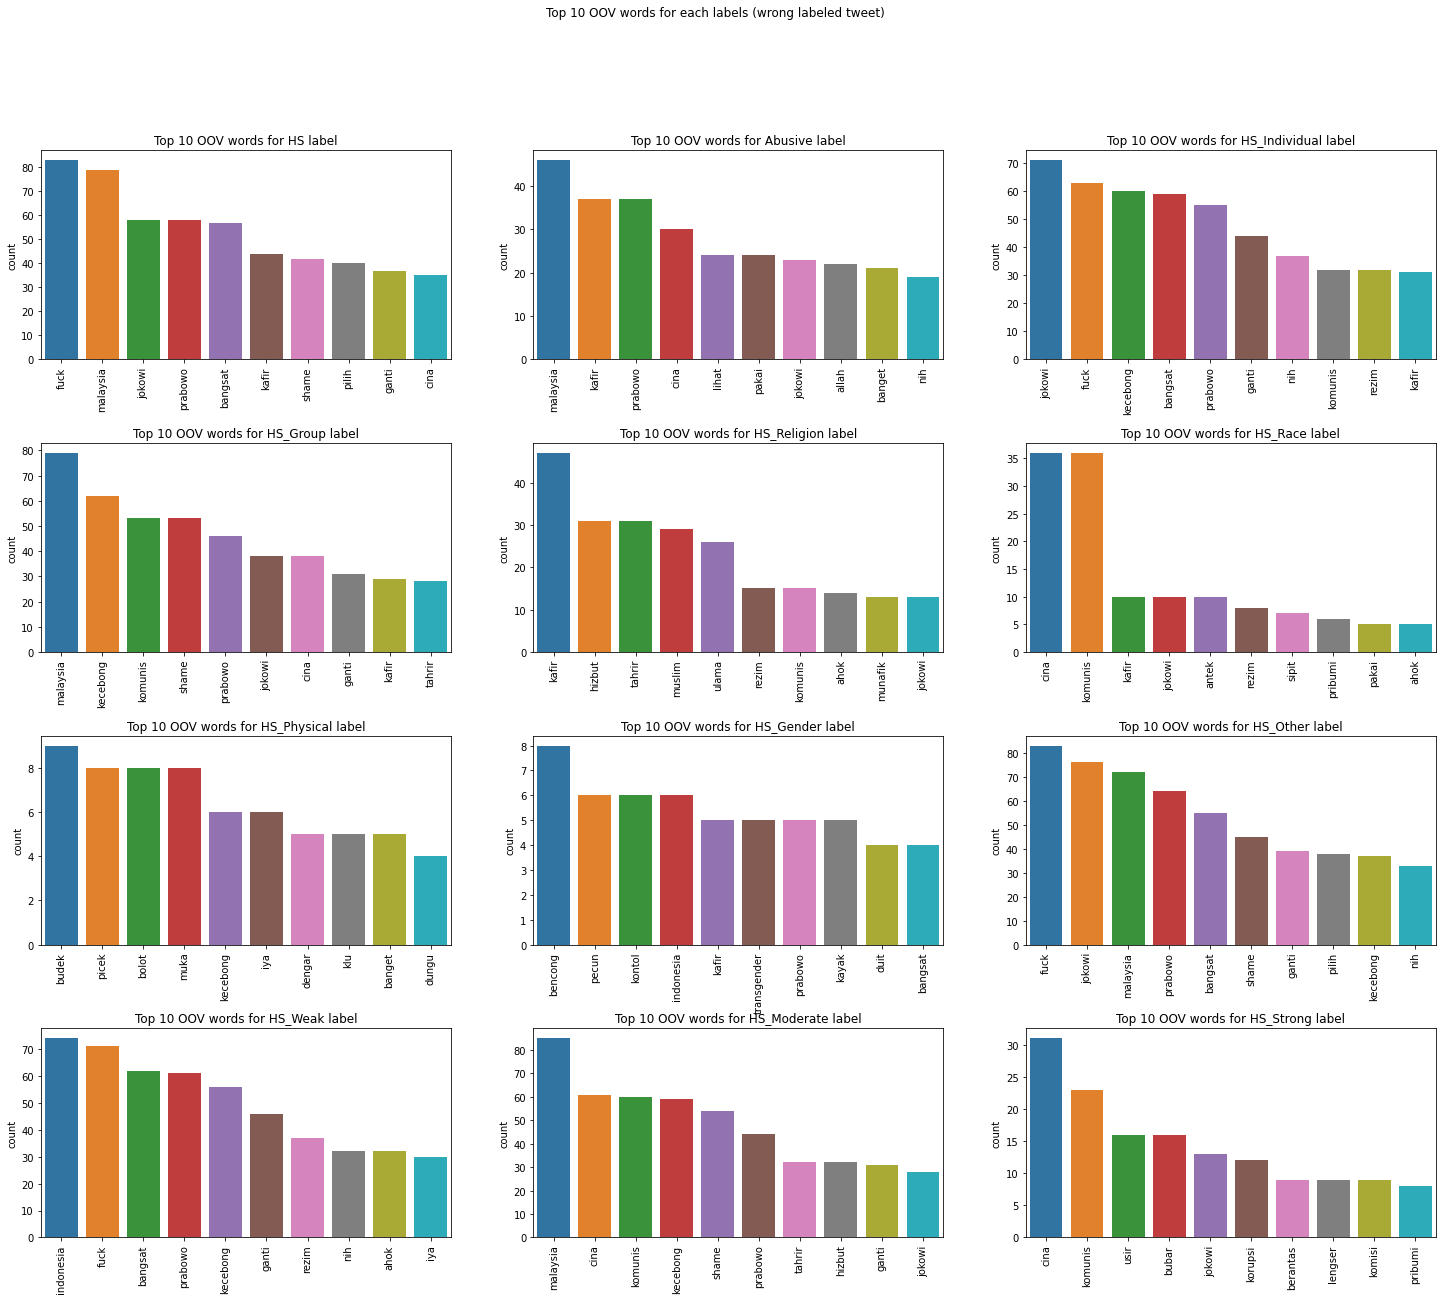

In [109]:
plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [110]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 'Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 "Hamdalah. Kelar juga ini fitur keparat.'",
 'Tasik Chini yg diiktiraf Rizab Biosfera oleh UNESCO sesungguhnya kaya dengan khazanah alam semulajadi, flora &amp; fauna.; ; Namun sejak 2009, persekitaran kawasan itu semakin terjejas akibat kegiatan pembalakan, perlombongan &amp; perladangan yg tidak ter',
 'HEBAHAN PENAWARAN PROGRAM DIPLOMA PENDIDIKAN LEPASAN IJAZAH (DPLI) DAN PROGRAM IJAZAH SARJANA MUDA PENDIDIKAN (PENDIDIKAN ISLAM) (ISMPPI) KEMASUKAN SEPTEMBER 2018 DI UNISZA.; ; Sukacita dimaklumkan bahawa Universiti Sultan Zainal...',
 "USER Sebenernya siapa sih yang mempunyai hak untuk menyatakan bahwa orang itu kafir? Dan jika semua orang mempunyai hak, apa kriteria kafir itu?'",
 "USER USER USER USER U

In [111]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng berengsek think nothing remember',
 'insult one cina kafir make good muslim',
 'user ajar garong kafir',
 'user anak pecun hobi zina',
 'hamdalah selesai fitur keparat',
 'tasik chini iktiraf rizab biosfera unesco sungguh kaya khazanah alam flora fauna kawasan pengaruh akibat giat bala lombong ladang ter',
 'hibah tawar program diploma didik lepas ijazah dpli program ijazah sarjana muda didik didik islam ismppi masuk september unisza sukacita maklum universitas sultan zainal',
 'user hak nyata orang kafir orang hak kriteria kafir',
 'user user user user user user iya tante jablay',
 'indonesia literally suffocate air pollution kampung people tonton sampah burn',
 'user astaga sewa pecun',
 'user pilih bunga bangkai karang bunga',
 'cheat menang distinguish loser shame malaysia sea game',
 'beli barang kirim cina paket transit cinta indonesia minggu',
 'pork najis orang dirty consider akin drink urine least sub continent context reason final barrier pikir like temptation',
 'd

In [112]:
miss_exact_tweet_test.iloc[:,1:-13].columns

Index(['Tweet', 'HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion',
       'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak',
       'HS_Moderate', 'HS_Strong'],
      dtype='object')

In [113]:
# real label
miss_exact_tweet_test.iloc[:,1:-13].values.tolist()

[["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0],
 ['Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ["USER Khan yg ngajarin si garong kafir'",
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0],
 ["USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0],
 ["Hamdalah. Kelar juga ini fitur keparat.'",
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['Tasik Chini yg diiktiraf Rizab Biosfera oleh UNESCO sesungguhnya kaya dengan khazanah alam semulajadi, flora &amp; fauna.; ; Namun sejak 2009, persekitaran kawasan itu semakin terjejas akibat kegiatan pembalakan, perlombongan &amp; perladangan yg tidak ter',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ['HEBAHAN PENAWARAN PROGRAM DIPLOMA P

In [114]:
miss_exact_tweet_test.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [115]:
miss_exact_tweet_test

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed,HS_predict,Abusive_predict,HS_Individual_predict,HS_Group_predict,HS_Religion_predict,HS_Race_predict,HS_Physical_predict,HS_Gender_predict,HS_Other_predict,HS_Weak_predict,HS_Moderate_predict,HS_Strong_predict
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng berengsek think nothing remember,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,insult one cina kafir make good muslim,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,USER Khan yg ngajarin si garong kafir',1,1,1,0,1,0,0,0,0,1,0,0,user ajar garong kafir,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,USER Anak pecun... ga jauh2 dr hobi zina.. haha',1,1,1,0,0,0,0,1,0,1,0,0,user anak pecun hobi zina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,Hamdalah. Kelar juga ini fitur keparat.',0,1,0,0,0,0,0,0,0,0,0,0,hamdalah selesai fitur keparat,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,3672,"No more bullshit, chief! RT USER: President S...",1,1,1,0,0,0,0,0,1,1,0,0,bullshit chief user presiden susilo bambang yu...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3673,3674,"we told you, the FANATIC is the worst. no matt...",1,0,0,1,0,0,0,0,1,0,1,0,tell fanatic bad matter organization shame mal...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3675,3676,bangsat HAHAHAHAHA RT fuckboysehun: so whose f...,1,1,1,0,0,0,0,0,1,1,0,0,bangsat fuch boy hun whose falsetto high fuck,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3678,3679,USER USER Mestinya nanti Fahri hamzah di kasih...,1,0,1,0,0,0,0,0,1,1,0,0,user user fahri hamzah kasih kerja bawa ta pre...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
